<a href="https://colab.research.google.com/github/studentAybu/ML_GlobalCountryMetrics2025/blob/main/ML_GlobalCountryMetrics2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/prashantdhanuk/global-country-metrics-2025-hdi-gdp-pop-area?resource=download")

Skipping, found downloaded files in "./global-country-metrics-2025-hdi-gdp-pop-area" (use force=True to force download)


In [6]:
import pandas as pd

# reading the file
file =('/content/global-country-metrics-2025-hdi-gdp-pop-area/countries_metric - Sheet1.csv')
newData = pd.read_csv(file)
newData = newData.dropna()
newData = newData.convert_dtypes()

# displaying the contents of the file
newData.head()

,country_name,Population (in millions),Nominal Gross Domestic Product (in USD),Nominal GDP Per capita (in USD),GDP Per capita PPP (in USD),Human Development Index (HDI),GINI,AREA (in Sq km)
0,Afghanistan,"41,454,761",$17.329 billion,411,"2,174",0.496,35.2,"652,867"
1,Albania,"2,402,113",$28.372 billion,"10,526","23,404",0.81,33.0,"28,748"
2,Algeria,"46,700,000",$266.78 billion,"5,722","16,483",0.763,27.6,"2,381,741"
3,Andorra,"87,486",$3.897 billion,"44,900","69,146",0.913,40.0,467.63
4,Angola,"39,040,039",$93.796 billion,"2,432",7077,0.616,51.3,"1,246,700"


from matplotlib import pyplot as plt
_df_0['Human Development Index (HDI)'].plot(kind='hist', bins=20, title='Human Development Index (HDI)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['GINI'].plot(kind='hist', bins=20, title='GINI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Human Development Index (HDI)', y='GINI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Human Development Index (HDI)'].plot(kind='line', figsize=(8, 4), title='Human Development Index (HDI)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['GINI'].plot(kind='line', figsize=(8, 4), title='GINI')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
newData.info()
print(newData.dtypes)


<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 193
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country_name                             174 non-null    string 
 1   Population (in millions)                 174 non-null    string 
 2   Nominal Gross Domestic Product (in USD)  174 non-null    string 
 3   Nominal GDP Per capita (in USD)          174 non-null    string 
 4   GDP Per capita PPP (in USD)              174 non-null    string 
 5   Human Development Index (HDI)            174 non-null    Float64
 6   GINI                                     174 non-null    Float64
 7   AREA (in Sq km)                          174 non-null    string 
dtypes: Float64(2), string(6)
memory usage: 12.6 KB
country_name                               string[python]
Population (in millions)                   string[python]
Nominal Gross Domestic Product (i

In [18]:
import re
def toNumericSeries(el):
  s=str(el)
  numeric_part = ''.join(re.findall(r"\d+", s))
  return float(numeric_part)

newData['numeric_area'] = newData['AREA (in Sq km)'].apply(toNumericSeries)
newData['numeric_population']=newData['Population (in millions)'].apply(toNumericSeries)
newData['numeric_gdp_per_capita'] = newData['GDP Per capita PPP (in USD)'].apply(toNumericSeries)
newData['numeric_nominal_gdp']=newData['Nominal GDP Per capita (in USD)'].apply(toNumericSeries)
newData['numeric_nominal_gross']=newData['Nominal Gross Domestic Product (in USD)'].apply(toNumericSeries)

print(newData.info())

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 193
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country_name                             174 non-null    string 
 1   Population (in millions)                 174 non-null    Int64  
 2   Nominal Gross Domestic Product (in USD)  174 non-null    string 
 3   Nominal GDP Per capita (in USD)          174 non-null    float64
 4   GDP Per capita PPP (in USD)              174 non-null    float64
 5   Human Development Index (HDI)            174 non-null    Float64
 6   GINI                                     174 non-null    Float64
 7   AREA (in Sq km)                          174 non-null    float64
 8   numeric_area                             174 non-null    float64
 9   numeric_population                       174 non-null    float64
 10  numeric_gdp_per_capita                   174 non-null  

In [9]:
# Function to create HDI category
def categorize_hdi(hdi):
    if pd.isna(hdi):
        return pd.NA
    elif hdi <= 0.549:
        return 'Low'
    elif hdi <= 0.699:
        return 'Medium'
    elif hdi <= 0.799:
        return 'High'
    else:
        return 'Very High'

# Add HDI category column
newData['HDI_category'] = newData['Human Development Index (HDI)'].apply(categorize_hdi)

# Population density (population as integer, area in km2)
newData['population_density'] = (newData['numeric_population'] * 1_000_000) / newData['numeric_area']

# Total GDP (Nominal GDP Per capita * population)
newData['total_gdp'] = newData['numeric_gdp_per_capita'] * (newData['numeric_population'] * 1_000_000)

print(newData[['population_density', 'total_gdp', 'HDI_category']].head())
print(newData['HDI_category'].value_counts(dropna=False))


   population_density     total_gdp HDI_category
0        6.349649e+07  9.012265e+16          Low
1        8.355757e+07  5.621905e+16    Very High
2        1.960751e+07  7.697561e+17         High
3        1.870838e+06  6.049307e+15    Very High
4        3.131470e+07  2.762864e+17       Medium
HDI_category
Very High    65
High         43
Medium       40
Low          26
Name: count, dtype: int64


In [10]:
import pandas as pd

def clean_numeric_column(df, column_name, remove_chars=None):
    """
    Cleans the specified column and converts it to numeric type (float64).
    remove_chars: list of characters to remove (e.g., [',', '$'])
    """
    df = df.copy()
    series = df[column_name].astype(str)

    if remove_chars:
        for ch in remove_chars:
            series = series.str.replace(ch, '', regex=True)

    series = series.str.strip()

    df[column_name] = pd.to_numeric(series, errors='coerce').astype(float)

    nan_count = df[column_name].isna().sum()
    print(f"Number of NaNs in '{column_name}': {nan_count}")
    print(df[column_name].head())
    return df


def clean_population_column(df, column_name):
    """
    Cleans the population column, converts it to numeric type (Int64),
    and adds a new column for population in millions (float).
    """
    df = df.copy()
    series = df[column_name].astype(str).str.replace(',', '', regex=True).str.strip()
    df[column_name] = pd.to_numeric(series, errors='coerce').astype('Int64')

    nan_count = df[column_name].isna().sum()
    print(f"Number of NaNs in '{column_name}': {nan_count}")

    df['Population_million'] = df[column_name].astype(float) / 1_000_000
    print(df[[column_name, 'Population_million']].head())
    return df


newData = clean_population_column(newData, 'Population (in millions)')

newData = clean_numeric_column(newData, 'Nominal GDP Per capita (in USD)', remove_chars=[',', '$'])
newData = clean_numeric_column(newData, 'GDP Per capita PPP (in USD)', remove_chars=[',', '$'])
newData = clean_numeric_column(newData, 'AREA (in Sq km)', remove_chars=[',', '$'])

print(newData['Nominal GDP Per capita (in USD)'].dtype)
print(newData['GDP Per capita PPP (in USD)'].dtype)
print(newData['AREA (in Sq km)'].dtype)

for col in ['Nominal GDP Per capita (in USD)', 'GDP Per capita PPP (in USD)', 'AREA (in Sq km)']:
    non_numeric = newData[~newData[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric[[col]].head())


Number of NaNs in 'Population (in millions)': 0
   Population (in millions)  Population_million
0                  41454761           41.454761
1                   2402113            2.402113
2                  46700000           46.700000
3                     87486            0.087486
4                  39040039           39.040039
Number of NaNs in 'Nominal GDP Per capita (in USD)': 0
0      411.0
1    10526.0
2     5722.0
3    44900.0
4     2432.0
Name: Nominal GDP Per capita (in USD), dtype: float64
Number of NaNs in 'GDP Per capita PPP (in USD)': 0
0     2174.0
1    23404.0
2    16483.0
3    69146.0
4     7077.0
Name: GDP Per capita PPP (in USD), dtype: float64
Number of NaNs in 'AREA (in Sq km)': 0
0     652867.00
1      28748.00
2    2381741.00
3        467.63
4    1246700.00
Name: AREA (in Sq km), dtype: float64
float64
float64
float64


<Axes: >

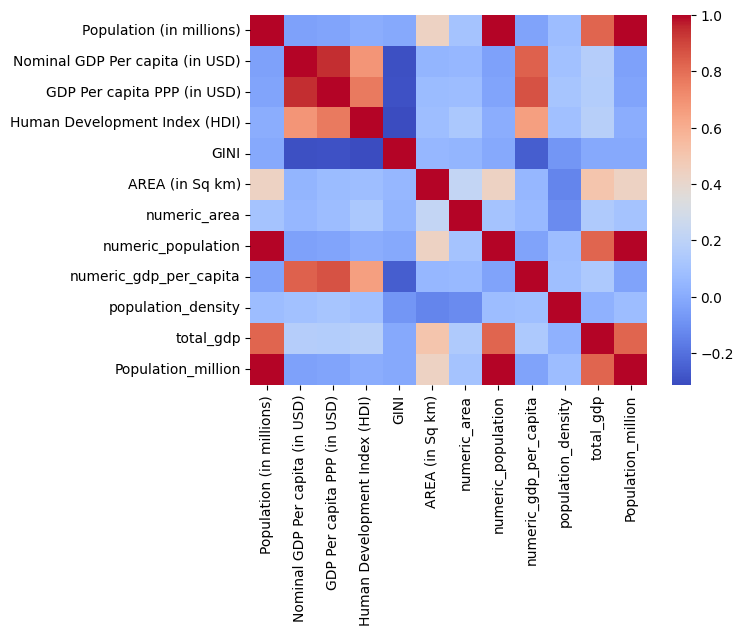

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = newData.corr(numeric_only= True)
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")


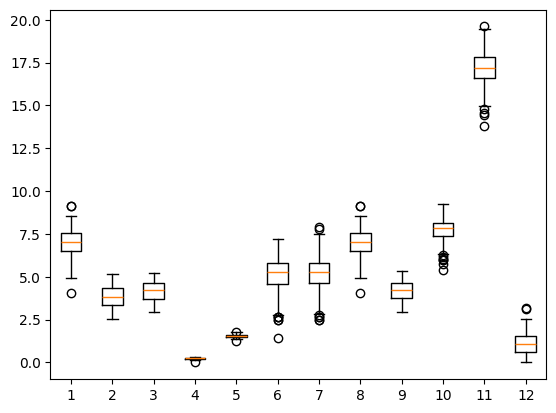

In [12]:
import numpy as np
plt.boxplot(np.log10(newData.select_dtypes(include=['number'])+1))
plt.show()

Index(['country_name', 'Population (in millions)',
       'Nominal Gross Domestic Product (in USD)',
       'Nominal GDP Per capita (in USD)', 'GDP Per capita PPP (in USD)',
       'Human Development Index (HDI)', 'GINI', 'AREA (in Sq km)',
       'numeric_area', 'numeric_population', 'numeric_gdp_per_capita',
       'HDI_category', 'population_density', 'total_gdp',
       'Population_million'],
      dtype='object')


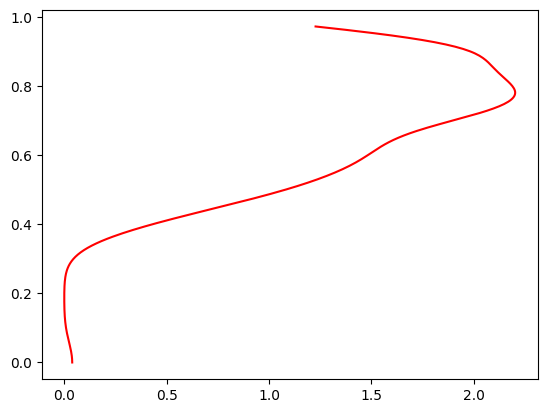

In [13]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(newData['Human Development Index (HDI)'])
x_vals = np.linspace(min(newData['Human Development Index (HDI)']), max(newData['Human Development Index (HDI)']), 300)
plt.plot(kde(x_vals), x_vals, label='Smoothed (KDE)', color='red')
print(newData.columns)


,numeric_population,numeric_area,numeric_gdp_per_capita,numeric_nominal_gdp,numeric_nominal_gross,GINI
0,4.145476e+07,6528670.00,21740.0,4110.0,17329.0,35.2
1,2.402113e+06,287480.00,234040.0,105260.0,28372.0,33.0
2,4.670000e+07,14903241.25,164830.0,57220.0,26678.0,27.6
3,8.748600e+04,46763.00,691460.0,449000.0,3897.0,40.0
4,3.904004e+07,12467000.00,70770.0,24320.0,93796.0,51.3
...,...,...,...,...,...,...
189,3.051826e+07,9164450.00,79850.0,34740.0,92210.0,44.8
190,8.167818e+07,14903241.25,154700.0,46230.0,201114.5,36.1
191,4.138553e+07,4555030.00,20530.0,6170.0,21045.0,36.7
192,2.021603e+07,7526170.00,40680.0,14350.0,29536.0,51.5


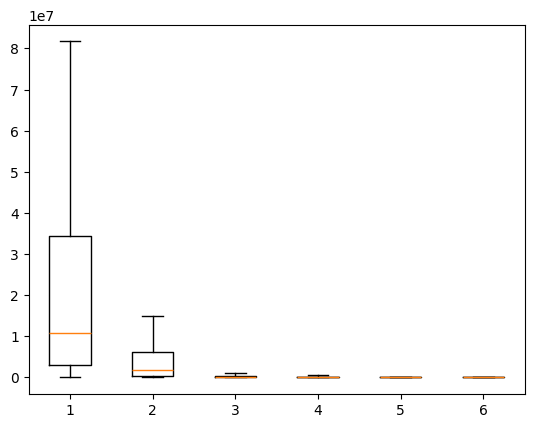

from matplotlib import pyplot as plt
feature_table['numeric_population'].plot(kind='hist', bins=20, title='numeric_population')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_area'].plot(kind='hist', bins=20, title='numeric_area')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_gdp_per_capita'].plot(kind='hist', bins=20, title='numeric_gdp_per_capita')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_nominal_gdp'].plot(kind='hist', bins=20, title='numeric_nominal_gdp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table.plot(kind='scatter', x='numeric_population', y='numeric_area', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table.plot(kind='scatter', x='numeric_area', y='numeric_gdp_per_capita', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table.plot(kind='scatter', x='numeric_gdp_per_capita', y='numeric_nominal_gdp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table.plot(kind='scatter', x='numeric_nominal_gdp', y='numeric_nominal_gross', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_population'].plot(kind='line', figsize=(8, 4), title='numeric_population')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_area'].plot(kind='line', figsize=(8, 4), title='numeric_area')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_gdp_per_capita'].plot(kind='line', figsize=(8, 4), title='numeric_gdp_per_capita')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature_table['numeric_nominal_gdp'].plot(kind='line', figsize=(8, 4), title='numeric_nominal_gdp')
plt.gca().spines[['top', 'right']].set_visible(False)

In [60]:
def fit_outliers(x, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    if x > upper:
        return upper
    elif x < lower:
        return lower
    else:
        return x
def iterate_for_outliers(numeric_dataset):
  df = numeric_dataset
  for col in df.columns:
    sf = df[col].quantile(0.75)
    tf = df[col].quantile(0.25)
    df[col] = df[col].apply(lambda x: fit_outliers(x,tf,sf))

feature_table = newData[['numeric_population','numeric_area','numeric_gdp_per_capita','numeric_nominal_gdp','numeric_nominal_gross','GINI']].copy()
target_table = newData[['Human Development Index (HDI)']].copy()
iterate_for_outliers(feature_table)
iterate_for_outliers(target_table)
plt.boxplot(feature_table)
feature_table

